## Week 4 Video Notebook -- Testing and Validation for Fitting a Polynomial Model


The goal of this notebook and video are to continue to explore the question raised at the end of the last video: How do we choose the **right** model, neither underfitting nor overfitting?

The key insight presented this week is that we can simulate having new data by separating our dataset into training, validation, and testing sets. As long as these sets are kept separate, the performance of a model on the final testing set is a good indicator of how well the model generalizes.  Validation sets are an intermediate testing set that alternate with bouts of training. 

This notebook and video show how to determine the degree of the best-fitting polynomial model using 3 different paradigms. 

- Train/Test split (for a warm-up, its not actually legit to select a model based on the test set!)
- Train/Validation/Test split
- Cross-Validation plus final test

In [1]:
# Useful imports

import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from numpy import arange,linspace,mean, var, std
from numpy.random import random, normal 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks

from tqdm import tqdm

# globals

random_state = 42            # every run will be random but repeatable
# random_state = None        # every run will be different

# Utility code

def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

# np.set_printoptions(precision=4, suppress=True) 


In [2]:
def make_polynomial_regression( size = 100,
                                degree=6,
                                error_std=10,
                                linear_spacing=False,
                                show_model=True,
                                display_dataset=True,
                                random_state=random_state
                              ):

    amplitude=50
    extrema_std=20    
    x_spacing=5 
    
    x_lb = 0
    
    if degree <= 4:              # rough heuristic for getting reasonable-looking curvesc
        x_ub = 60
    else:
        x_ub = 100 * (degree-4)

    y_anchors = []

    np.random.seed(42)

    for k in range(2*degree-1):
        t = k % 4
        if t in [0,2]:
            y_anchors.append(0)
        elif t == 1:
            y_anchors.append(np.random.normal(amplitude,extrema_std))
        else:
            y_anchors.append(np.random.normal(-amplitude,extrema_std))
            
    x_anchors = np.linspace(x_lb+x_spacing,x_ub-x_spacing,2*degree-1)
    
    # Fit a D-th degree polynomial
    coefs = np.polyfit(x_anchors, y_anchors, deg=degree)
    poly_func = np.poly1d(coefs)

    # Evaluate polynomial on a dense grid for plotting
    x_dense = np.linspace(x_lb, x_ub, 1000)    
    y_dense = poly_func(x_dense)
    
    # Generate dataset
    if linear_spacing:
        X = np.linspace(x_lb, x_ub, size)
    else:
        np.random.seed(random_state)
        X = np.random.uniform(low=x_lb, high=x_ub, size=size)
    
    np.random.seed(random_state)
    residuals = np.random.normal(0, error_std, size=size)
    y = poly_func(X) + residuals   # Drop any extra 1e14 scaling

    mse = np.mean(residuals**2)

    # Plot
    if display_dataset:
        plt.figure(figsize=(10, 6))
        plt.title(f"Degree {degree} Polynomial Dataset")
        if show_model:
            plt.plot(x_dense, y_dense, color='grey', alpha=0.5, label="Model w/o Noise")
        plt.scatter(X, y, marker='.', label="Noisy Data")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.legend()
        plt.show()
    
    return np.array(X), np.array(y), mse


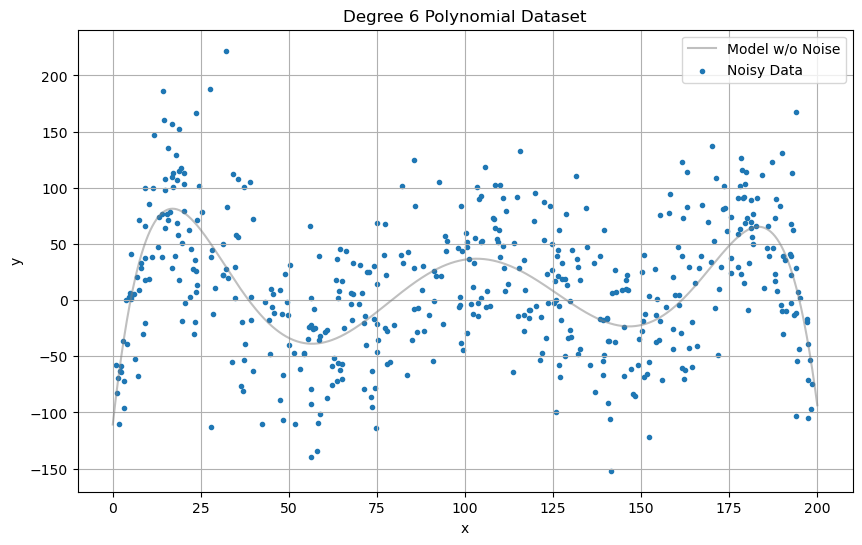

MSE (Irreducible Error): 2402.4474


In [3]:
size_ = 500
degree_ = 6
error_std_ = 50
linear_spacing_ = False

(X,y,mse) = make_polynomial_regression( size = size_,
                                        degree = degree_,
                                        error_std = error_std_,
                                        linear_spacing = linear_spacing_,
                                        random_state   = random_state,
#                                         show_model = False
                                      )

print(f'MSE (Irreducible Error): {mse:.4f}')

### Your Turn!

Experiment with different values for the parameters to `make_polynomial_regression` and observe
the results. 

### 1. Static Train / Test Split

First let's consider how to choose the degree of polynomial model that best fits the dataset
by evaluating the MSE on the test set.   This is actually **NOT** appropriate, since that would be like taking the final exam in a class multiple times to see what you should study. However, its useful to see how it works and compare it with the two better frameworks presented afterwards. 

In [4]:
# static train/test split


def train_test(X,y,test_size=0.2,degree_ub=12,show_plot=True,random_state=random_state,use_tqdm=True):

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                       )

    train_mses = []
    test_mses = []

    iterator = tqdm(range(1, degree_ub + 1)) if use_tqdm else range(1, degree_ub + 1)

    for degree in iterator:

        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        model.fit(X_train.reshape(-1,1), y_train)

        # Train the model
        y_train_pred = model.predict(X_train.reshape(-1,1))
        y_test_pred = model.predict(X_test.reshape(-1,1))

        # Evaluate the model
        train_MSE = mean_squared_error(y_train,y_train_pred)
        test_MSE = mean_squared_error(y_test,y_test_pred)

        train_mses.append(train_MSE)
        test_mses.append(test_MSE)



    min_test_mse = np.min(test_mses)
    min_test_degree = np.where(test_mses == min_test_mse)[0][0]+1
    
    if show_plot:

        plt.title("Testing MSE vs Degree")
#         plt.plot(range(1,degree_ub+1),train_mses,marker='.',label="Training MSE")
        plt.plot(range(1,degree_ub+1),test_mses,marker='.',label="Testing MSE")
        plt.xlabel("Degree of Polynomial Model")
        plt.ylabel("MSE")
        plt.xticks(range(1,degree_ub+1))
    #     plt.ylim([0,10])
        plt.legend()
        plt.grid()
        plt.show()
        
        print(f'Minimum Test MSE {min_test_mse:.4f} at degree {min_test_degree}')

    return min_test_mse,min_test_degree,test_mses


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 394.40it/s]


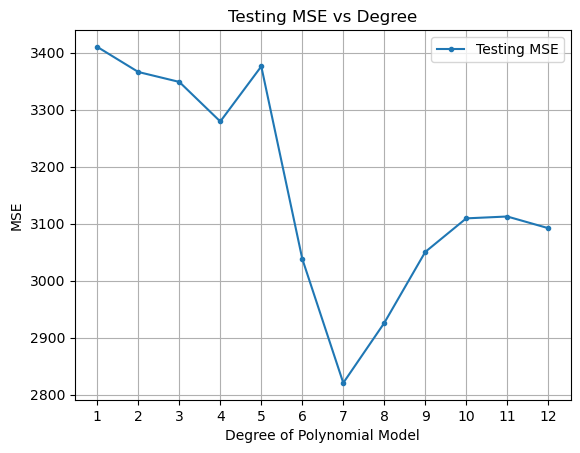

Minimum Test MSE 2820.7727 at degree 7


In [5]:
_ = train_test(X,y,test_size=0.2)

### Your Turn!

Again, create various datasets, and run `train_test` on each. 

- What is the effect on the plots of each of the parameters you experimented in above, in particular how well does it recognize the degree-6 polynomial model?


### 2. Static Train / Validation / Test 

Now we optimize training to the MSE on a fixed validation set. The test mse is
reported after training has finished. 

In [6]:
# sklearn's split can only do train/test, so we write our own

def train_validation_test_split(X,y,valid_size=0.2,test_size=0.2,random_state=random_state):
        
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=test_size+valid_size,random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=test_size/(test_size+valid_size),random_state=random_state)
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [7]:
# static train/valid/test split

def train_validation_test(X,y,valid_size=0.2,test_size=0.2,degree_ub=12,
                          show_plot=True,random_state=random_state,use_tqdm=True):

    X_train,X_valid,X_test,y_train,y_valid,y_test = (
        train_validation_test_split(X,y,
                                    valid_size=valid_size,
                                    test_size=test_size,
                                    random_state=random_state
                                   )
    )

    train_mses = []        
    valid_mses = []
    
    iterator = tqdm(range(1, degree_ub + 1)) if use_tqdm else range(1, degree_ub + 1)

    for degree in iterator:

        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

#         model = Pipeline([
#             ('scaler', StandardScaler()),
#             ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
#             ('linreg', LinearRegression())
#         ])

        # Train the model
        model.fit(X_train.reshape(-1,1), y_train)
        
        # Evaluate the model
        y_train_pred = model.predict(X_train.reshape(-1,1))
        y_valid_pred = model.predict(X_valid.reshape(-1,1))
        
        train_mse = mean_squared_error(y_train,y_train_pred)
        valid_mse = mean_squared_error(y_valid,y_valid_pred)
        
        train_mses.append(train_mse)
        valid_mses.append(valid_mse)

    min_valid_mse = np.min(valid_mses)
    min_valid_degree = np.where(valid_mses == min_valid_mse)[0][0]+1     

    best_model = make_pipeline(PolynomialFeatures(min_valid_degree), LinearRegression())
    best_model.fit(X_train.reshape(-1,1), y_train)

    y_test_pred = best_model.predict(X_test.reshape(-1,1))
    test_mse    = mean_squared_error(y_test,y_test_pred)

    if show_plot:

        plt.title("Validation MSE vs Degree")
#         plt.plot(range(1,degree_ub+1),train_mses,marker='.',label="Training mse")
        plt.plot(range(1,degree_ub+1),valid_mses,marker='.',label="Validation mse")
        plt.scatter([min_valid_degree],[test_mse],marker='x',color='red',label="Test mse")
        plt.xlabel("Degree of Polynomial Model")
        plt.ylabel("mse")
        plt.legend()
        plt.grid()
        plt.show()
        
        print(f'Minimum valididation mse {min_valid_mse:.4f} at degree {min_valid_degree}')
        print(f'Test mse at degree {min_valid_degree}:  {test_mse:.4f}')

    return min_valid_mse,min_valid_degree,test_mse,valid_mses

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 340.69it/s]


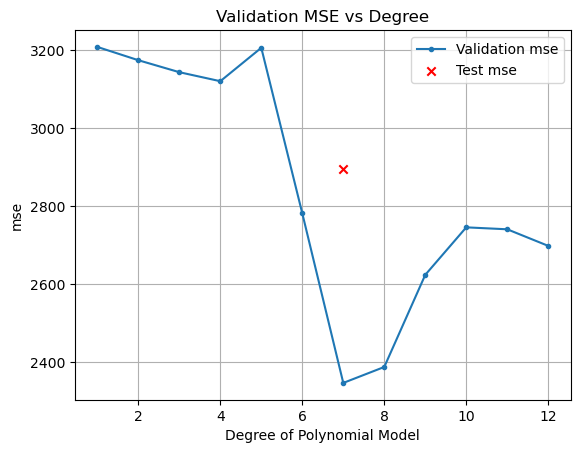

Minimum valididation mse 2347.5430 at degree 7
Test mse at degree 7:  2897.0271


In [8]:
_ = train_validation_test(X,y,test_size=0.2,valid_size=0.2)

### Your Turn!

Again, create various datasets, and run `train_test` on each. Try different test and validation percentages. 

- What is the effect on the plots of each of the parameters test_percent and valid_percent?
- How well does the framework help determine the correct model under various sizes and error stds?
- How well do the validation and test results compare?

### Cross-Validation Training with Final Test

In [9]:
# 5-fold Cross-validation plus held-out test set

def cross_validation_test(X,Y,test_size=0.2,loo=False,k_folds=5,
                          degree_ub=12,show_plot=True,random_state=random_state,
                          use_tqdm=True
                         ):

    # Split the data into training and test sets
    
    test_percent = 0.20
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_percent,random_state=random_state)

    X_train_reshaped = X_train.reshape(-1, 1)         # sklearn expects this format
    
    # Store mean training and cross-validation MSEs
    
    train_mses = []
    cv_mses = []

    if loo:
        cv = LeaveOneOut()
    else:
        cv = k_folds
        
    iterator = tqdm(range(1, degree_ub + 1)) if use_tqdm else range(1, degree_ub + 1)

    for degree in iterator:
        
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Compute cross-validation MSE (negative because sklearn minimizes internally)
        
        cv_scores = -cross_val_score(model, X_train_reshaped, 
                                     Y_train, scoring='neg_mean_squared_error', 
                                     cv=cv,
                                     n_jobs=-1
                                    )

        # Fit the model to calculate training MSE
        
        model.fit(X_train_reshaped, Y_train)
        Y_train_pred = model.predict(X_train_reshaped)
        train_mse = mean_squared_error(Y_train, Y_train_pred)

        train_mses.append( mean_squared_error(Y_train, Y_train_pred) )
        cv_mses.append( np.mean(cv_scores) )

    # Find the degree with the minimum cross-validation MSE
    
    min_cv_mse = np.min(cv_mses)
    min_cv_degree = np.argmin(cv_mses) + 1
    
#     print(f'Minimum Validation MSE {min_cv_mse:.4f} at degree {min_cv_degree}')

    # Train the final model on the full training set with the best degree
    
    final_model = make_pipeline(PolynomialFeatures(min_cv_degree), LinearRegression())
    final_model.fit(X_train_reshaped, Y_train)

    # Evaluate the model on the test set
    
    Y_test_pred = final_model.predict(X_test.reshape(-1, 1))
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    
#     print(f'Test MSE at degree {min_cv_degree}: {test_mse:.4f}')

    if show_plot:
        # Plot the MSE values
        if loo:
            plt.title("Training and LOO CV MSE vs Degree")
        else:
            plt.title("Training and Cross-Validation MSE vs Degree")
#         plt.plot(range(1, degree_ub + 1), train_mses, marker='.', label="Training MSE")
        plt.plot(range(1, degree_ub + 1), cv_mses, marker='.', label="Cross-Validation MSE")
        plt.scatter([min_cv_degree], [test_mse], marker='x', color='red', label="Test MSE")
        plt.xlabel("Degree of Polynomial Model")
        plt.ylabel("MSE")
#         plt.ylim([0,10])
        plt.legend()
        plt.grid()
        plt.show()
        
        print(f'Minimum Validation MSE {min_cv_mse:.4f} at degree {min_cv_degree}')
        print(f'Test MSE at degree {min_cv_degree}: {test_mse:.4f}')

    return min_cv_mse,min_cv_degree,test_mse,cv_mses


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.49it/s]


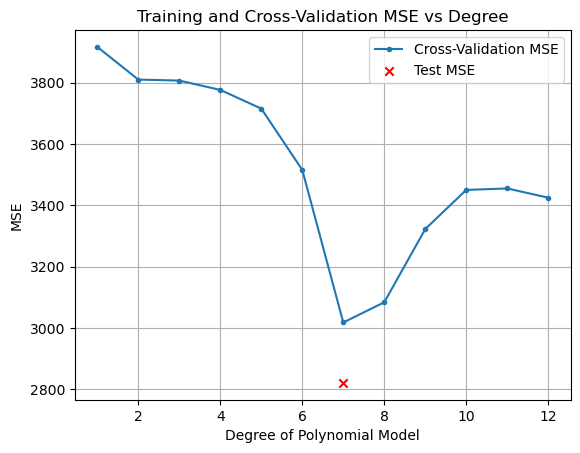

Minimum Validation MSE 3017.8315 at degree 7
Test MSE at degree 7: 2820.7727


In [10]:
_ = cross_validation_test(X,y,test_size=0.2,loo=False,k_folds=5)

### Leave-One-Out Cross-Validation

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.96it/s]


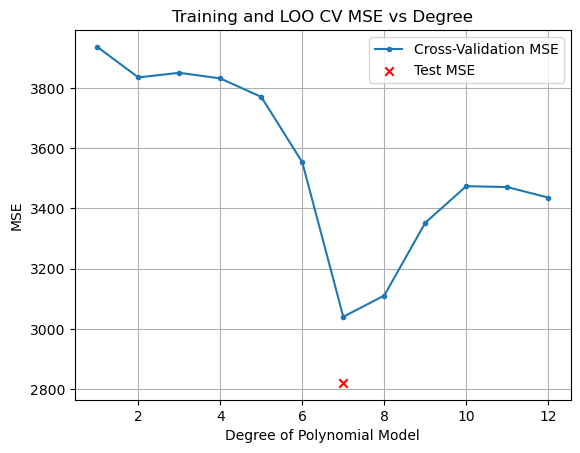

Minimum Validation MSE 3040.4149 at degree 7
Test MSE at degree 7: 2820.7727


In [11]:
_ =cross_validation_test(X,y,test_size=0.2,loo=True,k_folds=None,degree_ub=12,show_plot=True)



### Your Turn!

Again, create various datasets, and run `cross_validation_test` on each. Try different values for `k_folds` and also try LOOCV. 

- What is the effect on the plots of the various `k_folds`?
- How do they compare with LOOCV (which is in fact the case where `k_folds` = size of dataset)?

### Summing Up: Let's Compare

In [16]:
# Collect best model preds from all four options using defaults for error_std, and degree.
# It is useful when doing these kinds of comparisons to have as much data as possible, so we'll
# use size = 500

start = time.time()

num_trials = 1000

degree_ub = 12
                            
tt_mses = []
tvt_mses = []
cvt_mses = []
loocvt_mses = []

tt = []
tvt = []
cvt = []
loocvt = []

data_mses = []

for _ in tqdm(range(num_trials)):

    (X,y,mse) = make_polynomial_regression(size=100,
                                           degree= 6,
                                           error_std=50,
                                           show_model=False,
                                           linear_spacing = linear_spacing_,
                                           display_dataset=False,
                                           random_state=None       # more realistic: every run different
                                          )   

    data_mses.append(mse)
    
    min_test_mse,min_test_degree,_ = (
        train_test(X,y,test_size=0.2,degree_ub=degree_ub,
                   show_plot=False,random_state=None,use_tqdm=False)
    )
    
    min_valid_mse,min_valid_degree,test_mse,_ = (
        train_validation_test(X,y,test_size=0.2,valid_size=0.2,degree_ub=degree_ub,
                              show_plot=False,random_state=None,use_tqdm=False)
    )
    
    min_cv_mse,min_cv_degree,test_mse,_ = (
        cross_validation_test(X,y,test_size=0.2,loo=False,k_folds=5,degree_ub=degree_ub,
                              show_plot=False,random_state=None,use_tqdm=False)
    )
    
    min_loocv_mse,min_loocv_degree,test_mse,_ = (
        cross_validation_test(X,y,test_size=0.2,loo=True,k_folds=None,degree_ub=degree_ub,
                              show_plot=False,random_state=None,use_tqdm=False)
    )
    
    tt_mses.append(min_test_mse)
    tvt_mses.append(min_valid_mse)
    cvt_mses.append(min_cv_mse)
    loocvt_mses.append(min_loocv_mse)
    tt.append(min_test_degree)
    tvt.append(min_valid_degree)
    cvt.append(min_cv_degree)
    loocvt.append(min_loocv_degree)
    
# Record end time and execution time

end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████| 1000/1000 [09:39<00:00,  1.73it/s]

Execution Time: 9m 39.02s


size = 100	degree = 6	error_std = 50  linear spacing = False


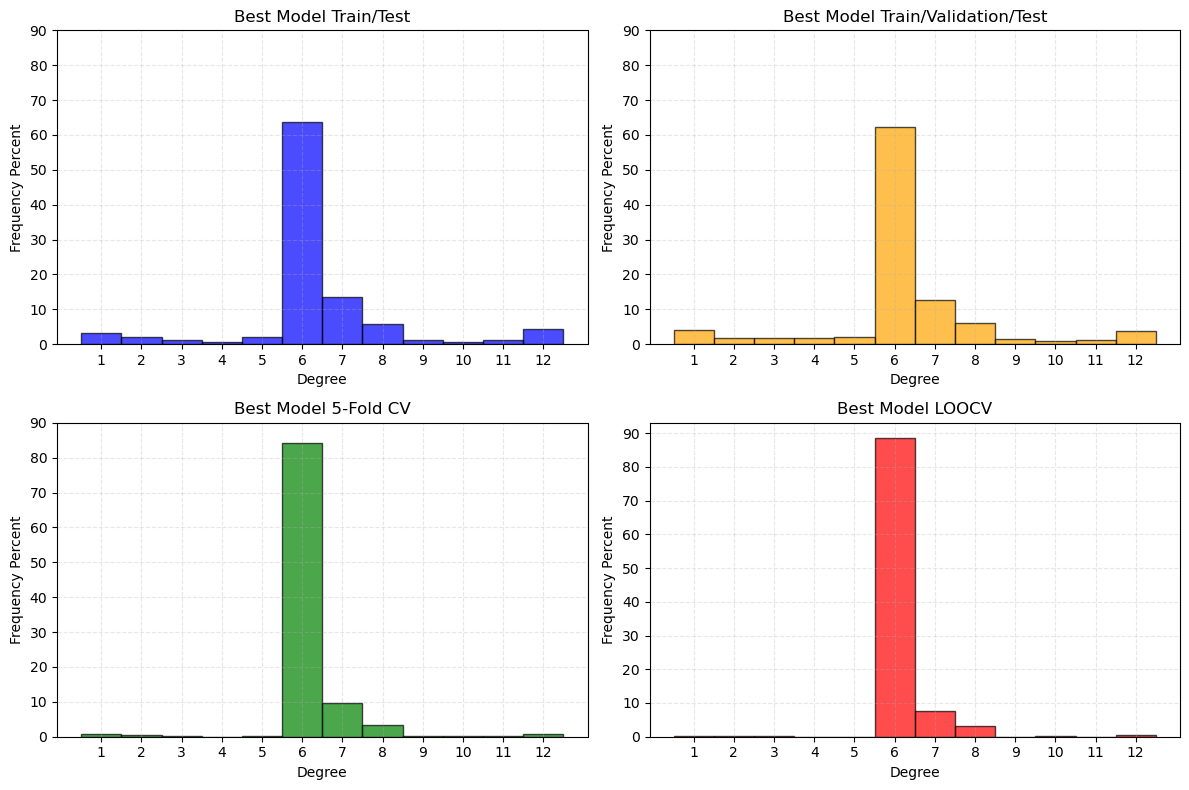

In [18]:
# Creating a 2x2 matrix of histograms

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# fig, axes = plt.subplots(2, 2, figsize=(8, 4))

data = [tt, tvt, cvt, loocvt]
titles = ['Best Model Train/Test', 'Best Model Train/Validation/Test', 'Best Model 5-Fold CV', 'Best Model LOOCV' ]
# titles = ['Best Model Train/Test', 'Best Model Train/Validation/Test' ]

colors = ['blue', 'orange','green', 'red']

print(f'size = {100}\tdegree = {degree_}\terror_std = {error_std_}  linear spacing = {linear_spacing_}')

# Plotting each histogram

for i, ax in enumerate(axes.flat):
    counts, bins, patches = ax.hist(
        data[i], 
        bins=np.arange(0.5,degree_ub+1.5,1), 
        color=colors[i], 
        edgecolor='black',
        alpha=0.7,
        weights=np.ones_like(data[i]) * 100 / len(data[i])  # Normalize to percentages
    )
    ax.set_title(titles[i])
    ax.set_xticks(np.arange(1, degree_ub+1))  # Set ticks from 1 to 15
    ax.set_xticklabels([int(x) for x in np.arange(1, degree_ub+1)])  # Set x-axis labels as integers
    ax.set_xlabel('Degree')
    
    # Set y-axis to percentages
    ax.set_ylabel('Frequency Percent')
    ax.set_yticks(np.arange(0, 100, 10))  # Set percentage tick marks
    
    ax.grid(True, linestyle='--', alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


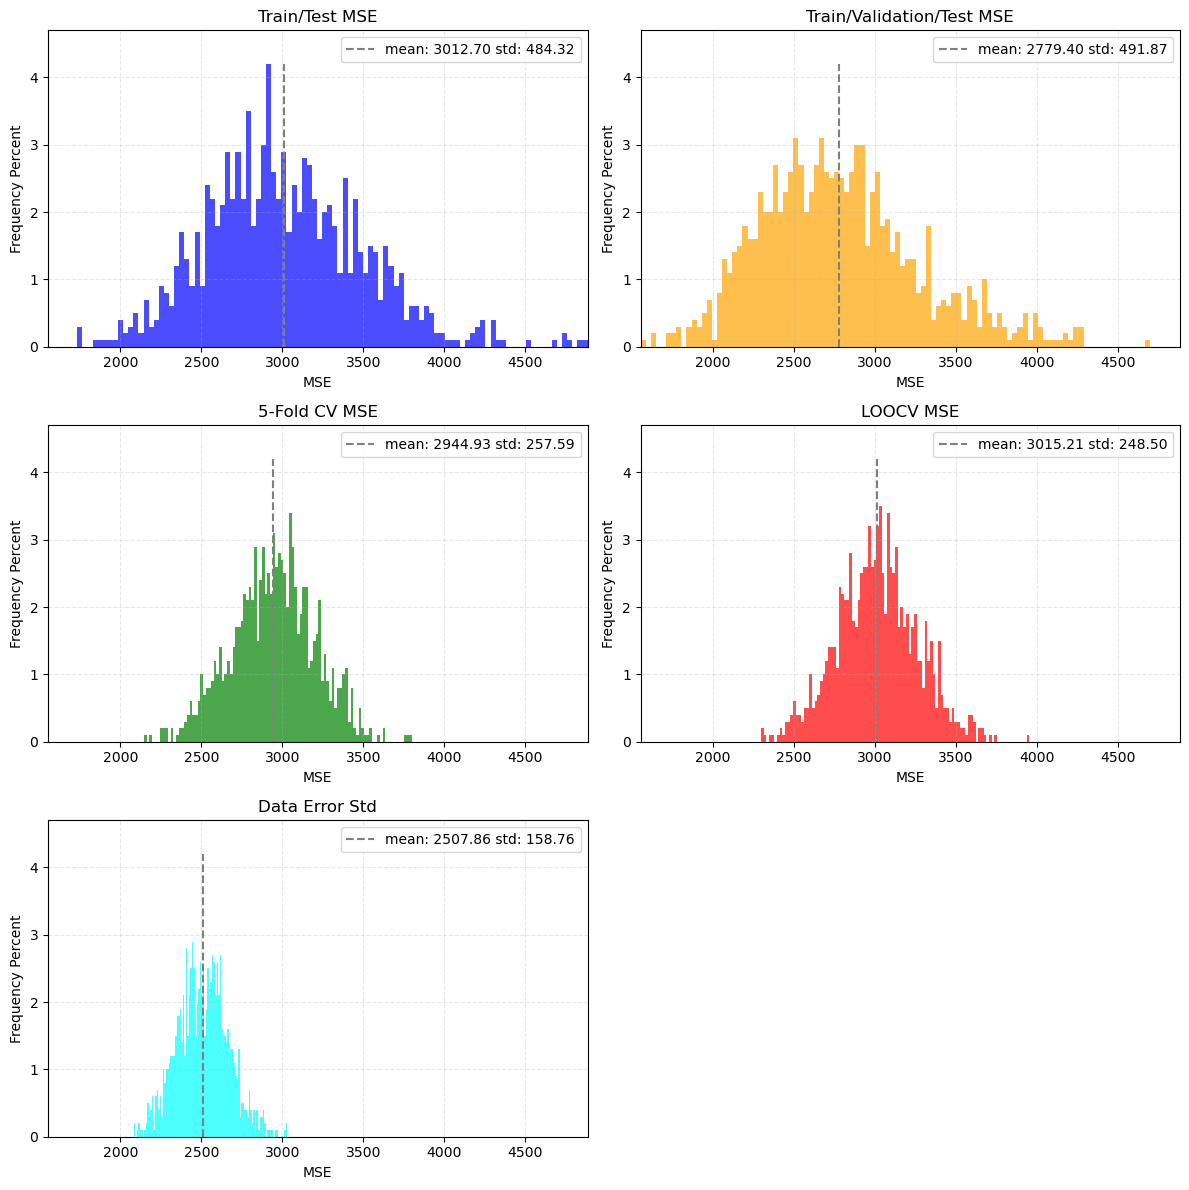

In [14]:
# Display MSE Histograms

# Data and metadata
data = [tt_mses, tvt_mses, cvt_mses, loocvt_mses, data_mses]
titles = ['Train/Test MSE', 'Train/Validation/Test MSE', '5-Fold CV MSE', 'LOOCV MSE', 'Data Error Std']
colors = ['blue', 'orange', 'green', 'red', 'cyan']

# Create subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten axes for easier iteration
axes = axes.flat

# Determine the common range for the x-axis
min_mse = min([min(d) for d in data])
max_mse = max([max(d) for d in data])

# Determine the common maximum y-axis value
max_y = 0
for d in data:
    counts, _ = np.histogram(d, bins=100)
    max_y = max(max_y, max(counts) * 100 / len(d))  # Normalize counts to percentages

# Plot histograms
for i in range(len(data)):
    ax = axes[i]
    counts, bins, patches = ax.hist(
        data[i],
        bins=100,
        color=colors[i],
        alpha=0.7,
        weights=np.ones_like(data[i]) * 100 / len(data[i])  # Normalize to percentages
    )
    ax.set_title(titles[i])
    ax.set_xlabel('MSE')
    ax.set_ylabel('Frequency Percent')
    m = np.mean(data[i])
    s = np.std(data[i])
    ax.plot([m, m], [0, max_y], linestyle='--', color='grey', label=f'mean: {m:.2f} std: {s:.2f}')
    ax.legend()
    ax.set_xlim(min_mse, max_mse)
    ax.set_ylim(0, max_y + 0.5)
    ax.grid(True, linestyle='--', alpha=0.3)

# Hide the unused subplot(s)
for j in range(len(data), len(axes)):
    axes[j].axis('off')  # Turn off unused subplot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Optional 

Again, play around with various settings for the parameters, and see how each framework did in terms of the variance of the results as shown by the histogram. 

- When does LOOCV have a smaller variance than 5-Fold CV?
- Does CV always do better than T/V/T?

### Very Optional

Here is a more granular version of cross validation. 
In this version, you can see every fold involved in every training and validation run, and
you can set the `random_state` to get the same folds each time, which is not possible in
`cross_validation_score`. 

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def custom_cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error',verbose=False,random_state=random_state):

    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)  # Shuffle and split data into folds
    scores = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model on the training set
        model.fit(X_train.reshape(-1,1), y_train)

        # Predict on the test set
        y_pred = model.predict(X_test.reshape(-1,1))

        # Calculate the desired score
        if scoring == 'neg_mean_squared_error':
            score = -mean_squared_error(y_test, y_pred)  # Negate MSE for compatibility
        else:
            raise ValueError(f"Unsupported scoring method: {scoring}")

        # Store the score
        scores.append(score)

        # Print details for demonstration
        if verbose:
            print(f"Fold {fold}: Test MSE = {mean_squared_error(y_test, y_pred):.4f}")

    return np.mean(scores)

# Example Usage

# Define the model
model = LinearRegression()

# Perform custom cross-validation
cv_score = custom_cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"\nMean CV Score: {-cv_score:.4f}")



Mean CV Score: 3857.1323


### Appendix: Additional Runs of Experiment

Here is one with 500 samples, degree 7, and error std = 25.  

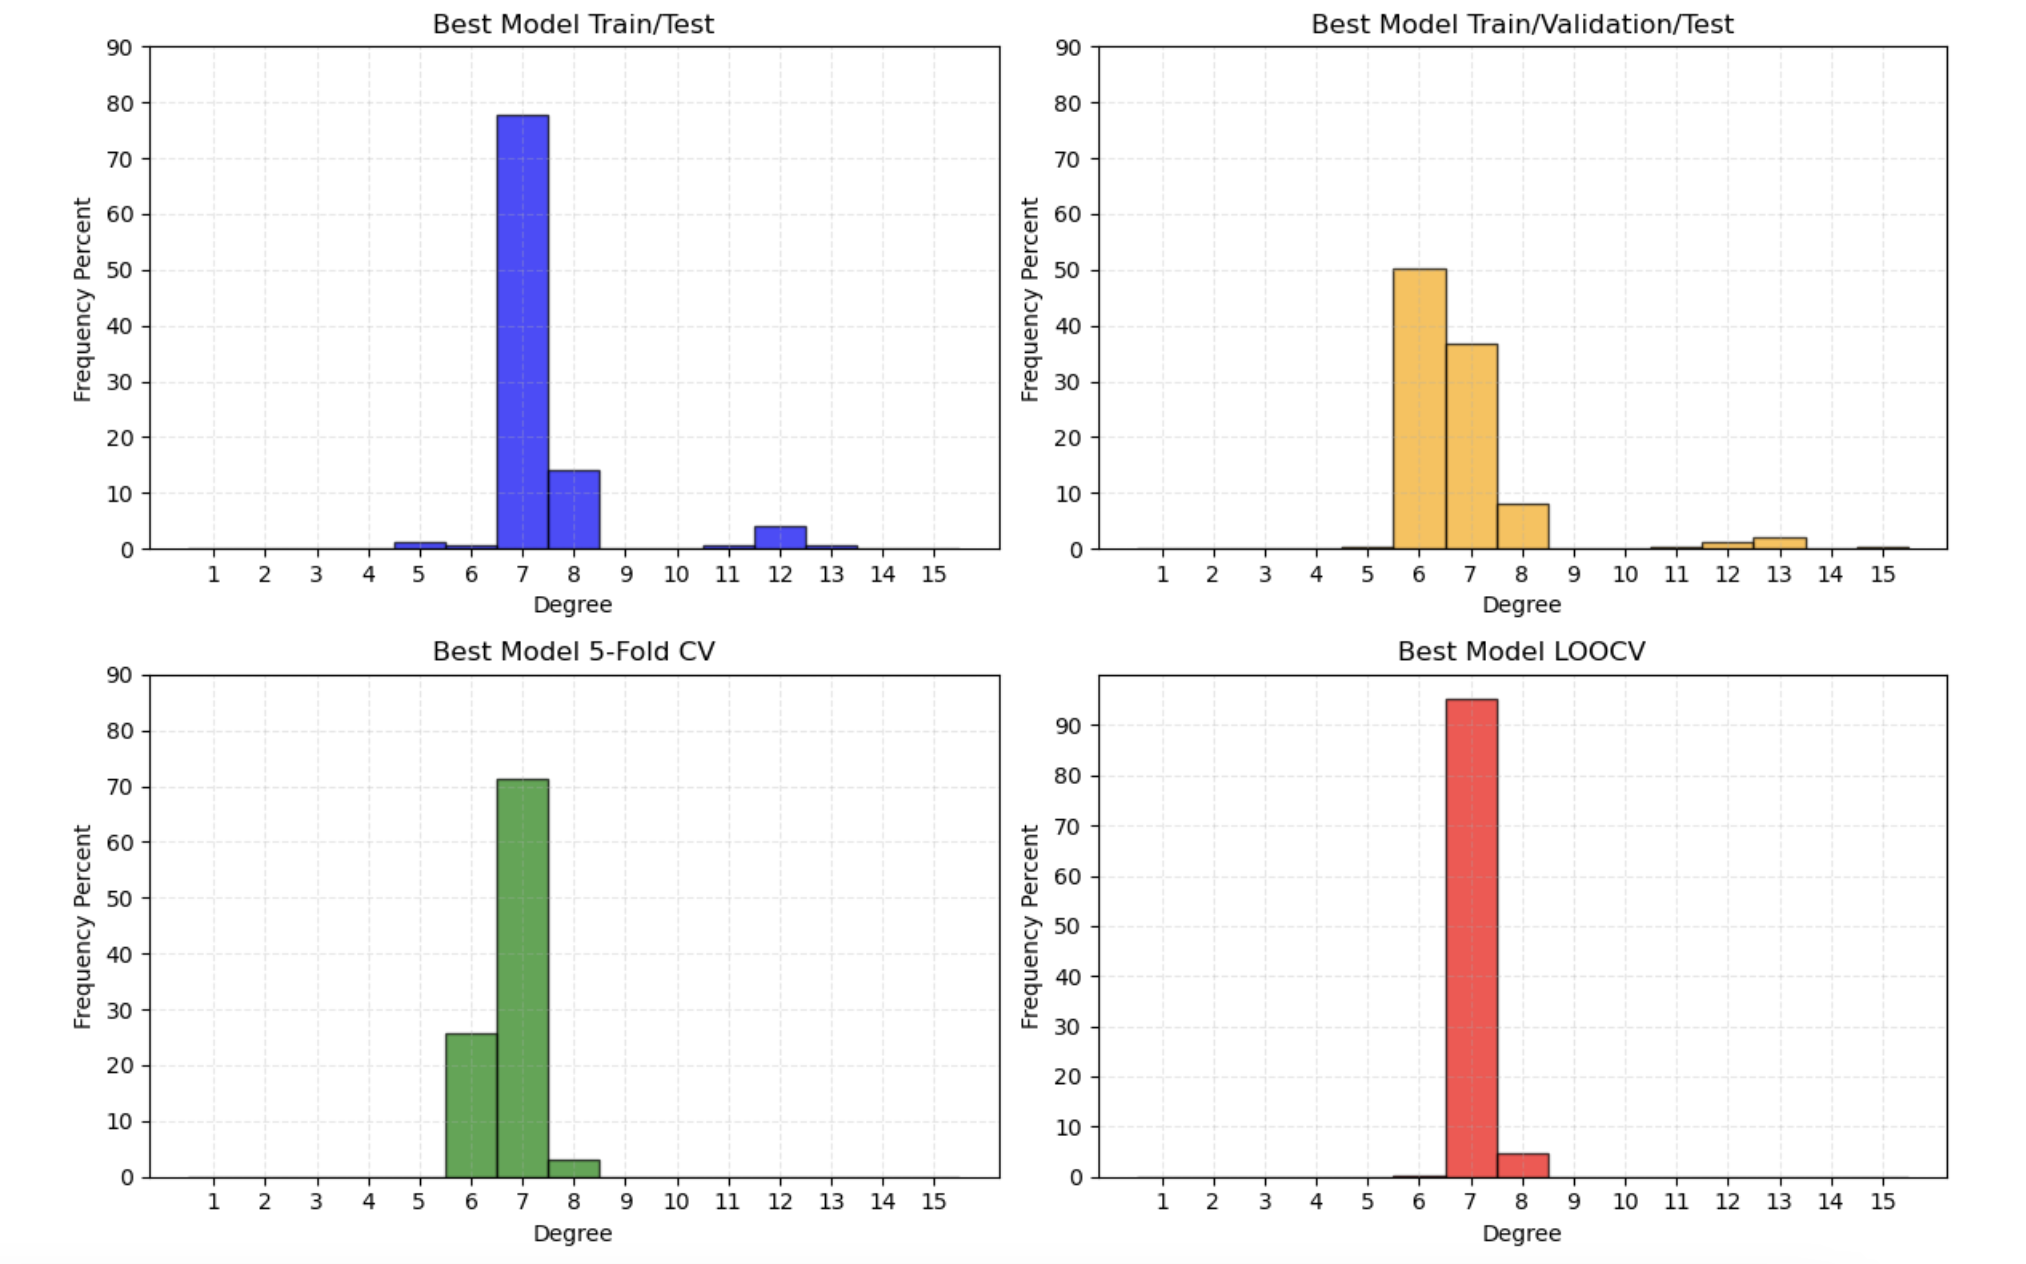

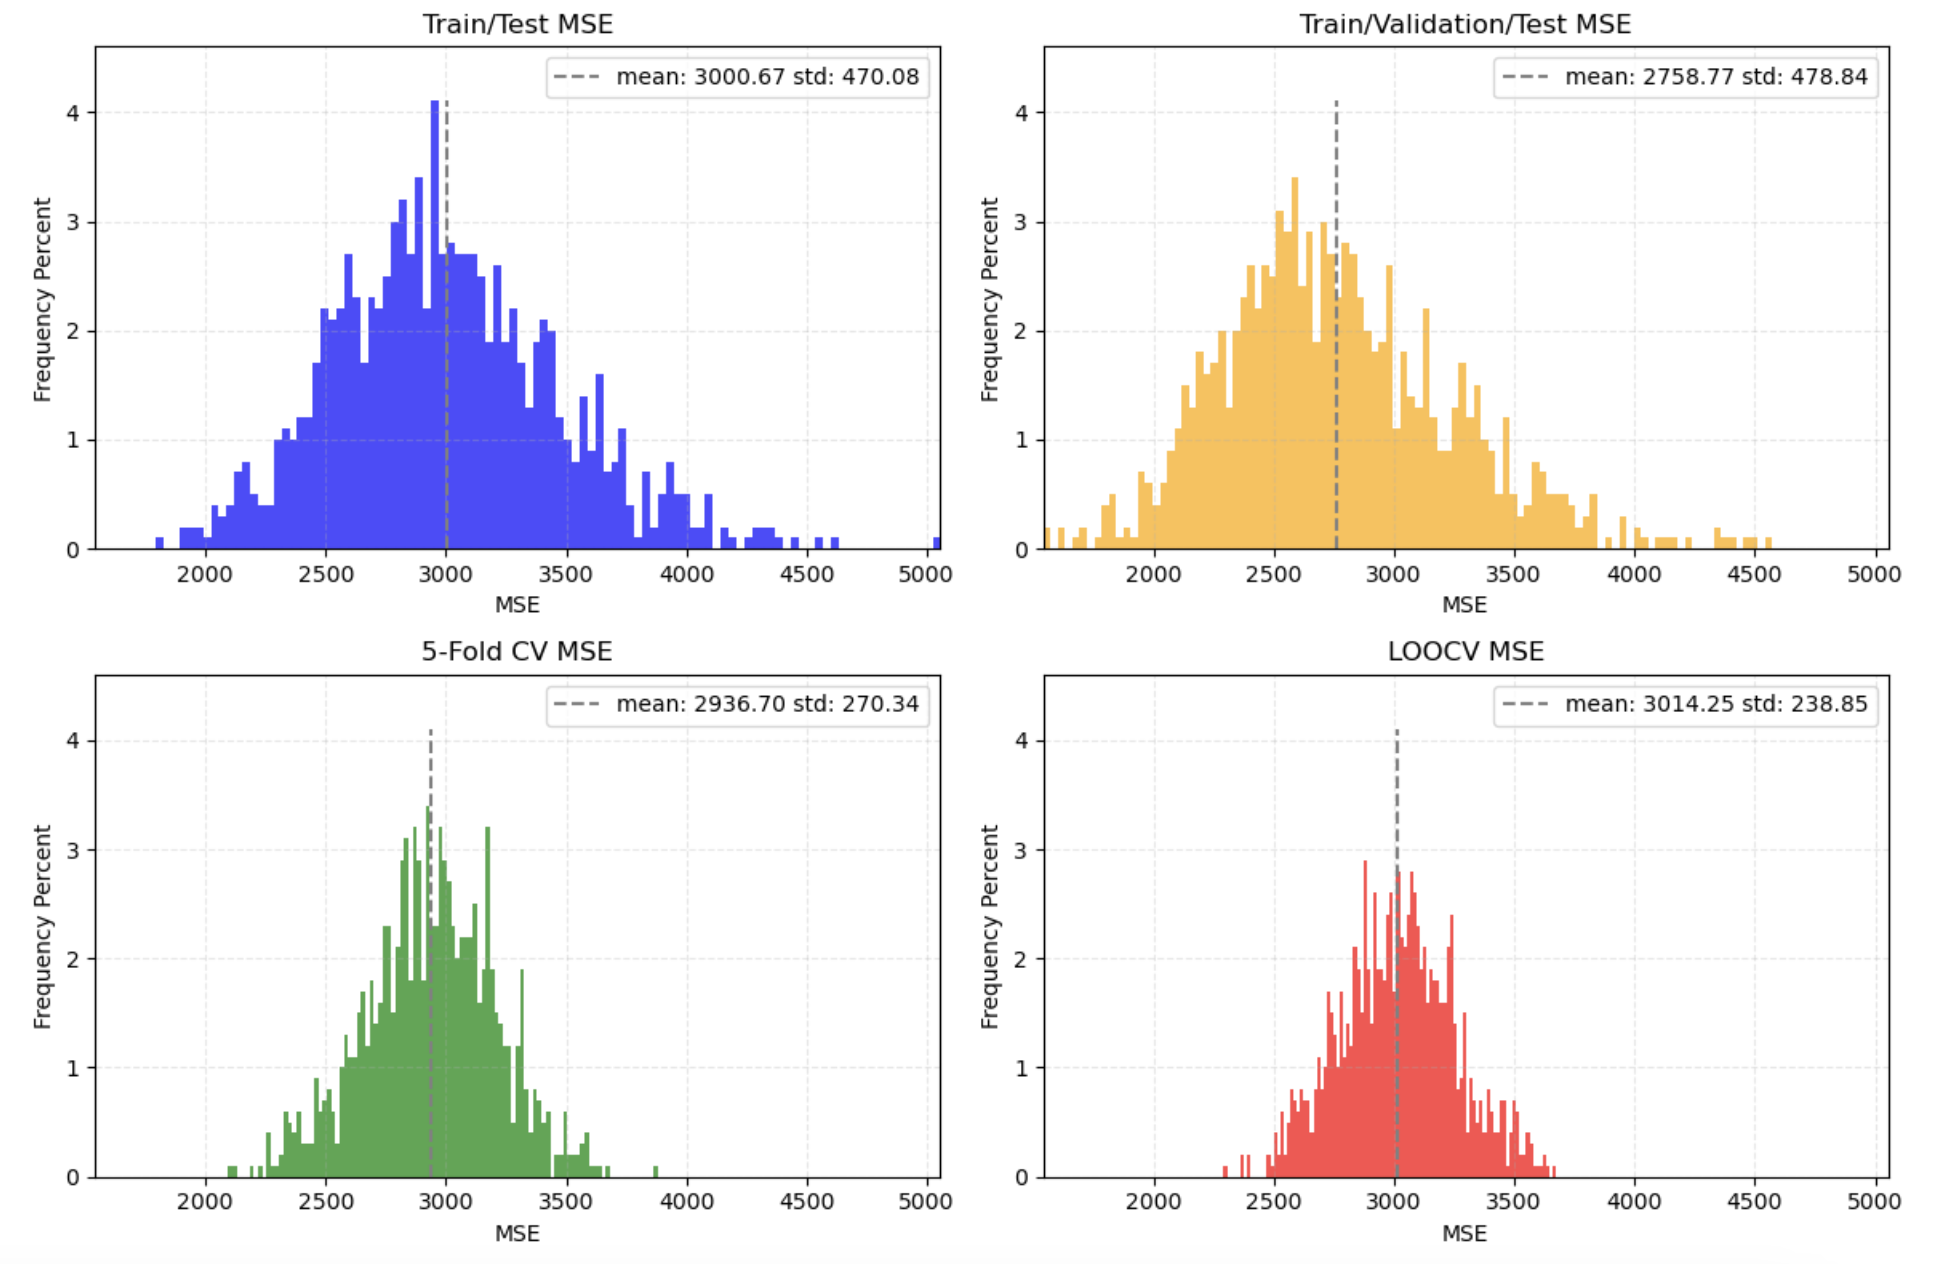